# Definindo o problema de negocio

De equipes de suporte de linha de frente a C-suites, a satisfação do cliente é uma medida chave de sucesso. Os clientes insatisfeitos não ficam por perto. Além do mais, clientes insatisfeitos raramente expressam sua insatisfação antes de sair.

O Banco Santander está pedindo aos Kagglers que os ajudem a identificar clientes insatisfeitos no início de seu relacionamento. Isso permitiria ao Santander tomar medidas proativas para melhorar a felicidade do cliente antes que seja tarde demais.

Nesta competição, você trabalhará com centenas de recursos anônimos para prever se um cliente está satisfeito ou insatisfeito com sua experiência bancária.Você recebe um conjunto de dados anônimo contendo um grande número de variáveis numéricas. A coluna "TARGET" é a variável a ser prevista. É igual a um para clientes insatisfeitos e 0 para clientes satisfeitos.

A tarefa é prever a probabilidade de cada cliente do conjunto de testes ser um cliente insatisfeito.

Você recebe um conjunto de dados anônimo contendo um grande número de variáveis numéricas. A coluna "TARGET" é a variável a ser prevista. É igual a um para clientes insatisfeitos e 0 para clientes satisfeitos.

A tarefa é prever a probabilidade de cada cliente do conjunto de testes ser um cliente insatisfeito.

Descrições de arquivo

train.csv - o conjunto de treinamento incluindo o alvo \
test.csv - o conjunto de teste sem o alvo \
sample_submission.csv - um arquivo de envio de amostra no formato correto

Para cada ID no conjunto de teste, você deve prever uma probabilidade para a variável TARGET. O arquivo deve conter um cabeçalho e ter o seguinte formato:

ID,TARGET \
2,0 \
5,0 \
6,0 \
etc.

As inscrições são avaliadas na área sob a curva ROC entre a probabilidade prevista e o alvo observado.

# Pacotes

In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'whitegrid')
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

# Funcoes

In [7]:
#Função para retirar variaveis com baixa variancia
def variance_threshold_selector(data, threshold=0):
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [8]:
#Funcão para Gerar Analise Bivariada

def eda_target(df, lst_variaveis, targetName='target', barIndice=False, barVariacao=False, barPeso=False):

#Indice Geral
    tab_geral = pd.DataFrame()
    tab_geral[targetName] = pd.Series(df[targetName].sum())
    tab_geral['Populacao'] = pd.Series(df[targetName].count())  
    tab_geral['Indice'] = np.round(tab_geral[targetName] / tab_geral['Populacao'], 4)
    tab_geral

    lst_tab = []
    for variavel in lst_variaveis:
        tab = df[[variavel, targetName]].groupby([variavel]).sum()
        tab['Populacao'] = df[[variavel, targetName]].groupby([variavel]).count()
        tab['Indice'] = np.round(tab[targetName] / tab.Populacao, 4)
        tab['Proporcao'] = np.round(tab.Populacao / np.sum(tab.Populacao), 2 )
        tab['Variacao'] = np.round((tab.Indice -  tab_geral.Indice.values) /  tab_geral.Indice.values, 2)
        tab['Peso']   = np.round(tab.Variacao * tab.Proporcao , 4)
        tab = tab.sort_values(by='Peso', ascending=False)
        lst_tab.append(tab)

#Grafico do Indice por categoria     
    if barIndice == True:
        for tabela in lst_tab:
            plt.figure(figsize = (4,2)) 
            ax=sns.barplot(y=tabela.index, x=tabela.Indice, orient="h", palette='Reds_r', 
                order=tabela.sort_values('Indice', ascending=False).index)
            ax.set(xlim=(0, 1))
            plt.tight_layout()
            plt.show()

#Variacao no Indice por categoria
    if barVariacao == True:
        for tabela in lst_tab:
            plt.figure(figsize = (4,2)) 
            ax=sns.barplot(y=tabela.index, x=tabela.Variacao, orient="h", palette='RdBu',
                  order=tabela.sort_values('Variacao', ascending=False).index)
            ax.set(xlim=(-1, 1))
            plt.tight_layout()
            plt.show()

#Peso de cada categoria considerando variacao e população     
    if barPeso == True:
        for tabela in lst_tab:
            plt.figure(figsize = (4,2)) 
            ax = sns.barplot(y=tabela.index, x=tabela.Peso, orient="h", palette='RdBu',
                  order=tabela.sort_values('Peso', ascending=False).index)
            ax.set(xlim=(-.25, .25))
            plt.tight_layout()
            plt.show()

    return lst_tab


# Carregando os Dados

In [24]:
#Carregando dados de treino
diretorio = 'C:/Users/mateus.sehn/OneDrive/Cursos/Big_Data_Real-Time_Com_Python_e_Spark/12-Projetos_Com_Feedback/'
arquivo = 'train.csv'

df = pd.read_csv(diretorio+arquivo)                  
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


# Analise Exploratoria

In [25]:
#Balanceamento Classes
df['TARGET'].value_counts(normalize=True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

É necessário balancear as classes ou utilizar alguma modelo que lide com classes desbalanceadas

In [26]:
#Verifica sem tem registros com chave duplicada
df['ID'].duplicated().sum()

0

Podemos exlcuir campo ID a partir deste ponto

In [27]:
#Qtd de Valores ausentes
print("\nValores Ausentes: \n" , df.isnull().sum().sum())


Valores Ausentes: 
 0


Não há necessidade de inputação de dados

In [28]:
#Informações basicas dataset (dtype e  Non-Null Count)
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 371 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    ID                             76020 non-null  int64  
 1    var3                           76020 non-null  int64  
 2    var15                          76020 non-null  int64  
 3    imp_ent_var16_ult1             76020 non-null  float64
 4    imp_op_var39_comer_ult1        76020 non-null  float64
 5    imp_op_var39_comer_ult3        76020 non-null  float64
 6    imp_op_var40_comer_ult1        76020 non-null  float64
 7    imp_op_var40_comer_ult3        76020 non-null  float64
 8    imp_op_var40_efect_ult1        76020 non-null  float64
 9    imp_op_var40_efect_ult3        76020 non-null  float64
 10   imp_op_var40_ult1              76020 non-null  float64
 11   imp_op_var41_comer_ult1        76020 non-null  float64
 12   imp_op_var41_comer_ult3       

Claramente há um certo padrão nas variáveis (saldo, num, ind, imp, delta e var)\

Existem dois tipos de variável:\
int64 aplicado basicamente para as variaveis dos grupos ind e num \
float64 aplicado principalmente para as variaveis dos grupos saldo, imp, delta

é provável que as técnicas de pré-processamento deverão ser diferencias para cada um dos grupos 

Também parece que os grupos são aspcetos diferentes de uma mesmo objeto (variavel). Ex: num_op_var39_ult1, num_op_var39_ult3,ind_var39, imp_op_var39_comer_ult1, imp_op_var39_comer_ult1 etc. Isso pode indicar um possível problema de multicolineariedade                 

In [29]:
# Sumário estatístico das variáveis numéricas
d = df
summ_num = pd.DataFrame(index = d.columns)
summ_num['Variavel'] = d.columns
summ_num['Tipo de Dado'] = d.dtypes.values
summ_num['# Registros Não Nulos'] = d.count().values
summ_num['# Registros Não Zero'] = d.astype(bool).sum(axis = 0)
summ_num['% Registros Não Zero'] = round(summ_num['# Registros Não Zero'] / d.shape[0]*100,2)
summ_num['% Populado'] = round(summ_num['# Registros Não Nulos'] / d.shape[0]*100,2)
summ_num['# Valores Únicos'] = d.nunique().values
summ_num['Mean'] = round(d.mean(),2)
summ_num['Std'] = round(d.std(),2)
summ_num['Min'] = round(d.min(),2)
summ_num['Max'] = round(d.max(),2)
summ_num[360:]

,Variavel,Tipo de Dado,# Registros Não Nulos,# Registros Não Zero,% Registros Não Zero,% Populado,# Valores Únicos,Mean,Std,Min,Max
saldo_medio_var29_ult3,saldo_medio_var29_ult3,float64,76020,3,0.00,100.0,4,0.19,31.88,0.00,7331.34
saldo_medio_var33_hace2,saldo_medio_var33_hace2,float64,76020,43,0.06,100.0,43,7.94,455.89,0.00,50003.88
saldo_medio_var33_hace3,saldo_medio_var33_hace3,float64,76020,24,0.03,100.0,24,1.37,113.96,0.00,20385.72
saldo_medio_var33_ult1,saldo_medio_var33_ult1,float64,76020,48,0.06,100.0,48,12.22,783.21,0.00,138831.63
saldo_medio_var33_ult3,saldo_medio_var33_ult3,float64,76020,48,0.06,100.0,48,8.78,538.44,0.00,91778.73
saldo_medio_var44_hace2,saldo_medio_var44_hace2,float64,76020,99,0.13,100.0,99,31.51,2013.13,0.00,438329.22
saldo_medio_var44_hace3,saldo_medio_var44_hace3,float64,76020,32,0.04,100.0,33,1.86,147.79,0.00,24650.01
saldo_medio_var44_ult1,saldo_medio_var44_ult1,float64,76020,141,0.19,100.0,141,76.03,4040.34,0.00,681462.90
saldo_medio_var44_ult3,saldo_medio_var44_ult3,float64,76020,141,0.19,100.0,141,56.61,2852.58,0.00,397884.30
var38,var38,float64,76020,76020,100.00,100.0,57736,117235.81,182664.60,5163.75,22034738.76


As Variaveis do grupo ind são boleanas.\
Existem colunas com 1 valor único que podem ser excluídas\
Existem colunas com baixo indice de valores diferentes de zero\
A var3 é uma coluna com 208 valores únicos. O valor -999999.0 parece indicar um erro de cadastro que pode ser tratado alterando o valor para -1
As variaveis do grupo saldo e imp em geral são float64 e possuem valores muito diferentes. Talvez seja necessário padronizar.

In [30]:
#Qtd média de valores únicos nas variáveis int64 do grupo num
summ_num[summ_num['Variavel'].str[:3] == 'num']['# Valores Únicos'].describe(percentiles=[.25, .5, .75, .90])

count    143.000000
mean      16.034965
std       26.085021
min        1.000000
25%        2.000000
50%        5.000000
75%       16.500000
90%       49.400000
max      172.000000
Name: # Valores Únicos, dtype: float64

Vamos considerar que variaveis com 50 registros únicos será tradas como categoricas.

# Pre Processamento

In [31]:
#Ponto de Restauração
df_bk1 = df.copy()
df = df_bk1.copy()

### Variaveis com Baixa Representatividade

In [32]:
#Exclui variavel  ID
df.drop('ID', axis=1, inplace=True)

In [33]:
#Exclui Colunas duplicadas
duplicados = []
print("Variaveis iguais\n") 
for i in range(len(df.columns)-1):
    coluna1 = df.iloc[:,i] 
    coluna2 = df.iloc[:,i+1]
    name1 = df.iloc[:,i].name
    name2 = df.iloc[:,i+1].name
    
    if sum(coluna1 != coluna2) == 0:
        print(name1, "==", name2)
        duplicados.append(name1)

df.drop(duplicados, axis = 1, inplace=True)
print('Deletado: ', duplicados, '\n') 
print('New shape: ', df.shape)

Variaveis iguais

ind_var2_0 == ind_var2
ind_var13_medio_0 == ind_var13_medio
ind_var18_0 == ind_var18
ind_var25_0 == ind_var25
ind_var27_0 == ind_var28_0
ind_var28_0 == ind_var28
ind_var28 == ind_var27
ind_var32_0 == ind_var32
ind_var34_0 == ind_var34
ind_var37_0 == ind_var37
ind_var46_0 == ind_var46
num_var13_medio_0 == num_var13_medio
num_var18_0 == num_var18
num_var26_0 == num_var26
num_var25_0 == num_var25
num_var27_0 == num_var28_0
num_var28_0 == num_var28
num_var28 == num_var27
num_var32_0 == num_var32
num_var34_0 == num_var34
num_var37_0 == num_var37
num_var46_0 == num_var46
saldo_var28 == saldo_var27
num_var2_0_ult1 == num_var2_ult1
Deletado:  ['ind_var2_0', 'ind_var13_medio_0', 'ind_var18_0', 'ind_var25_0', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var32_0', 'ind_var34_0', 'ind_var37_0', 'ind_var46_0', 'num_var13_medio_0', 'num_var18_0', 'num_var26_0', 'num_var25_0', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var32_0', 'num_var34_0', 'num_var37_0', 'num_var46_0', '

In [34]:
#Trantando outlier na VAR3
df['var3'].replace(-999999, -1, inplace=True)

In [20]:
%%time
#Acha profundidade com melhor capacidade de generalização

#Separa Variaveis preditoras e alvo
X = df.drop('TARGET', axis=1)
y = df['TARGET']
    
#Divide dados de treino e validação   
x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
       
#Cria um dicionario para receber os scores do cross validation
scores = dict()

#Aplica um loop for percorren uma lista de valores
for i in np.arange(3,16,1):
    
    #Cria estratégia de crossvalidate
    cv = StratifiedKFold(n_splits=3, shuffle=True)
    
    #Define metricas
    scoring = ['roc_auc']
    
    #Cria modelo
    model =  RandomForestClassifier(max_depth=i, n_jobs=-1, class_weight='balanced_subsample')   
    
    #Treina com validação cruzada
    results = cross_validate(model, x_train, y_train.values.ravel(), scoring=scoring, cv=cv, return_train_score=True)
    
    #Retorna scores para o hiperparametro testado
    scores[i] = results['train_roc_auc'].mean(), results['test_roc_auc'].mean(), results['test_roc_auc'].std()

#Cria um Dataframe com os scores para cada hiperparametro testado
scores_frame = pd.DataFrame(scores).transpose()
scores_frame.columns = ['Training Score','Validation Score', 'Validation Std']
scores_frame['Min'] = scores_frame['Validation Score'] - (2 * scores_frame['Validation Std'])
scores_frame['Max'] = scores_frame['Validation Score'] + (2 * scores_frame['Validation Std'])

#Plota o score medio de treino e validação para cada hiperparametro testado
scores_frame[['Training Score','Validation Score']].plot(figsize = (10, 5))

#Imprime tabela de scores
scores_frame

KeyboardInterrupt: 

No Baseline, o max_depth = 9 apresentou o melhor desempenho em validação antes de começar a entrar em uma zona de overfiting
porém o modelo max_depth 10 apresentou maior estabilidade, uma vez que o desvio padrão do score é menor.
Vamos Seguir com max_depth  = 10

,Training Score,Validation Score,Validation Std,Min,Max
0.000,0.866168,0.804579,0.008099,0.788381,0.820777
0.005,0.834334,0.798573,0.009574,0.779425,0.817721
0.010,0.834871,0.801493,0.009410,0.782672,0.820313
0.015,0.837946,0.807884,0.005716,0.796452,0.819316
0.020,0.749925,0.724675,0.006008,0.712658,0.736692
0.025,0.750646,0.724286,0.012427,0.699431,0.749140


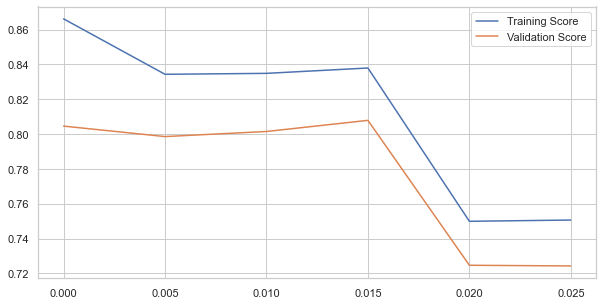

In [78]:
#Redução com base em baixa variação
scores = dict()
for threshold in np.arange(0, 0.03, 0.005):
    
    #Separa Variaveis preditoras e alvo
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    
    #Normaliza os dados (escala entre 0 e 1)
    X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
    
    #Retira variaveis com  variancia abaixo do limite
    X = variance_threshold_selector(X, threshold=threshold)
    
    #Divide dados de treino e validação   
    x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
    
    #Cria estratégia de crossvalidate
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    #Cria modelo
    model =  RandomForestClassifier(max_depth=10, n_jobs=-1, class_weight='balanced_subsample')
        
    #Define metricas
    scoring = ['roc_auc']
    
    #Treina com validação cruzada
    results = cross_validate(model, x_train, y_train.values.ravel(), scoring=scoring, cv=cv, return_train_score=True)
    
    #Retorna scores para o hiperparametro testado
    scores[threshold] = results['train_roc_auc'].mean(), results['test_roc_auc'].mean(), results['test_roc_auc'].std()
    
    #Cria um Dataframe com os scores para cada hiperparametro testado
scores_frame = pd.DataFrame(scores).transpose()
scores_frame.columns = ['Training Score','Validation Score', 'Validation Std']
scores_frame['Min'] = scores_frame['Validation Score'] - (2 * scores_frame['Validation Std'])
scores_frame['Max'] = scores_frame['Validation Score'] + (2 * scores_frame['Validation Std'])

#Plota o score medio de treino e validação para cada min_samples_leaf
scores_frame[['Training Score','Validation Score']].plot(figsize = (10, 5))

#Imprime tabela de scores
scores_frame

Vamos usar o limite de variancia 0.015 para excluir features 

In [35]:
#Retira variaveis com baixa variancia
df = variance_threshold_selector(df, threshold=0.01)
print("New shape: ", df.shape)

New shape:  (76020, 267)


In [37]:
#Redução com base em baixa indice de valores diferentes de zero

d = df
summ_num = pd.DataFrame(index = d.columns)
summ_num['Tipo de Dado'] = d.dtypes.values
summ_num['# Registros Não Nulos'] = d.count().values
summ_num['# Registros Não Zero'] = d.astype(bool).sum(axis = 0)
summ_num['% Registros Não Zero'] = round(summ_num['# Registros Não Zero'] / d.shape[0]*100,2)
summ_num['% Populado'] = round(summ_num['# Registros Não Nulos'] / d.shape[0]*100,2)
summ_num['# Valores Únicos'] = d.nunique().values
summ_num['Mean'] = round(d.mean(),2)
summ_num['Std'] = round(d.std(),2)
summ_num['Min'] = round(d.min(),2)
summ_num['Max'] = round(d.max(),2)
summ_num[:60]

scores = dict()
for threshold in np.arange(0, 3, 0.25):
    
    #Separa Variaveis preditoras e alvo
    X = df.drop('TARGET', axis=1).copy()
    y = df['TARGET']
        
    #Retira variaveis com % de valores não zeros abaixo do limite
    variaveis_nao_zero = summ_num.drop('TARGET')[summ_num['% Registros Não Zero'] <= threshold].index.to_list()
    X.drop(variaveis_nao_zero, axis=1, inplace=True)
    
    #Divide dados de treino e validação   
    x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.70)
    
    #Cria estratégia de crossvalidate
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    #Cria modelo
    model =  RandomForestClassifier(max_depth=10, n_jobs=-1, class_weight='balanced_subsample')

    #Define metricas
    scoring = ['roc_auc']  
    
    #Treina com validação cruzada
    results = cross_validate(model, x_train, y_train.values.ravel(), scoring=scoring, cv=cv, return_train_score=True, return_estimator=True)
    
    #Retorna scores para o hiperparametro testado
    scores[threshold] = results['train_roc_auc'].mean(), results['test_roc_auc'].mean(), results['test_roc_auc'].std()
    
#Cria um Dataframe com os scores para cada hiperparametro testado
scores_frame = pd.DataFrame(scores).transpose()
scores_frame.columns = ['Training Score','Validation Score', 'Validation Std']
scores_frame['Min'] = scores_frame['Validation Score'] - (2 * scores_frame['Validation Std'])
scores_frame['Max'] = scores_frame['Validation Score'] + (2 * scores_frame['Validation Std'])

#Plota o score medio de treino e validação para cada min_samples_leaf
scores_frame[['Training Score','Validation Score']].plot(figsize = (10, 5))

#Imprime tabela de scores
scores_frame

KeyboardInterrupt: 

Ao retirarmos as variaveis com menos de 1% de valores não zeros, o modelo apresentou melhora no score de validação

In [38]:
#Exclui variaveis com menos de 1 % de registros não zeros
variaveis_nao_zero = summ_num.drop('TARGET')[summ_num['% Registros Não Zero'] <= 1].index.to_list()
df.drop(variaveis_nao_zero, axis=1, inplace=True)
print('New shape:', df.shape)

New shape: (76020, 144)


### Tratando a Multicolineariedade

In [39]:
#Ponto de Restauração 
df_bk2 = df.copy()
df = df_bk2.copy()

In [40]:

while True:
    # Sumário estatístico das variáveis numéricas
    d = df
    summ_num = pd.DataFrame(index = d.columns)
    summ_num['Tipo de Dado'] = d.dtypes.values
    summ_num['# Registros Não Nulos'] = d.count().values
    summ_num['# Registros Não Zero'] = d.astype(bool).sum(axis = 0)
    summ_num['% Registros Não Zero'] = round(summ_num['# Registros Não Zero'] / d.shape[0]*100,2)
    summ_num['% Populado'] = round(summ_num['# Registros Não Nulos'] / d.shape[0]*100,2)
    summ_num['# Valores Únicos'] = d.nunique().values
    summ_num['Mean'] = round(d.mean(),2)
    summ_num['Std'] = round(d.std(),2)
    summ_num['Min'] = round(d.min(),2)
    summ_num['Max'] = round(d.max(),2)
    summ_num[:60]

    #Separa variaveis numericas continuas
    cols_continuos = summ_num
    cols_continuos_lst = cols_continuos.index.to_list()
    cols_continuos_lst

    #Atribui valor de X
    X = df[cols_continuos_lst]

    #Normaliza os dados (escala entre 0 e 1)
    X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

    #Gera Matriz de Correlação
    corr_matrix = X.corr()

    #Coverte a matriz em um data frame com pares de variaveis e sua correlação
    corr_matrix = corr_matrix.unstack()
    corr_matrix = corr_matrix.reset_index()
    corr_matrix.columns = ['var1', 'var2', 'valor']

    #Retira os pares iguais
    corr_matrix = corr_matrix[corr_matrix.var1!=corr_matrix.var2]
    corr_matrix['valor_abs'] = abs(corr_matrix.valor)

    corr_matrix

    #Filtra as correlação a partir de um limite
    limite = 0.95
    corr_matrix_filter = corr_matrix[corr_matrix['valor_abs'] >= limite].sort_values('valor_abs', ascending=False)
    corr_matrix_filter

    #Gera par de variaveis altamente correlacionadas 
    pearson_pair = corr_matrix_filter.head(1)

    #Se atingir o limite sai do loop
    if pearson_pair.empty:
        break

    #Separa variaveis
    var1 = pearson_pair['var1'].values[0]
    var2 = pearson_pair['var2'].values[0]

    #Escolhe variavel com base na correlação com a variável target
    df[['TARGET', var1, var2]].corr()

    #Escolhe variavel com base na correlação com a variável target
    var_drop = df[['TARGET', var1, var2]].corr()['TARGET'].abs().sort_values().head(1).index

    #Exclui a variavel com menor correlação com a variável Target
    df.drop(var_drop,axis=1, inplace=True)

    print('Dropado: ',var_drop)
print("Fim")

Dropado:  Index(['delta_num_aport_var13_1y3'], dtype='object')
Dropado:  Index(['ind_var26_0'], dtype='object')
Dropado:  Index(['ind_var8'], dtype='object')
Dropado:  Index(['num_var8_0'], dtype='object')
Dropado:  Index(['num_var13_corto'], dtype='object')
Dropado:  Index(['num_var24'], dtype='object')
Dropado:  Index(['ind_var40_0'], dtype='object')
Dropado:  Index(['imp_op_var41_efect_ult3'], dtype='object')
Dropado:  Index(['num_op_var41_efect_ult3'], dtype='object')
Dropado:  Index(['num_op_var41_efect_ult1'], dtype='object')
Dropado:  Index(['ind_var1_0'], dtype='object')
Dropado:  Index(['imp_op_var41_efect_ult1'], dtype='object')
Dropado:  Index(['num_var45_ult3'], dtype='object')
Dropado:  Index(['num_var1_0'], dtype='object')
Dropado:  Index(['num_var24_0'], dtype='object')
Dropado:  Index(['saldo_var24'], dtype='object')
Dropado:  Index(['num_var13_corto_0'], dtype='object')
Dropado:  Index(['num_var5'], dtype='object')
Dropado:  Index(['num_op_var39_hace2'], dtype='object'

In [162]:
#eda_target(df,[var1, var2], 'TARGET' )

In [42]:
#Ponto de Restauração
df_bk3 = df.copy()
df = df_bk3.copy()

Wall time: 2min 36s


,Training Score,Validation Score,Validation Std,Min,Max
3,0.802883,0.796901,0.003832,0.789237,0.804564
4,0.815636,0.805112,0.013574,0.777964,0.832261
5,0.828407,0.812531,0.003686,0.805160,0.819902
6,0.840295,0.818097,0.006875,0.804347,0.831847
7,0.854393,0.820079,0.010200,0.799679,0.840480
8,0.866097,0.820092,0.005102,0.809888,0.830296
9,0.877952,0.818056,0.009405,0.799246,0.836865
10,0.886948,0.817657,0.009425,0.798807,0.836507
11,0.897226,0.814358,0.009375,0.795608,0.833107
12,0.903940,0.807796,0.007058,0.793679,0.821912


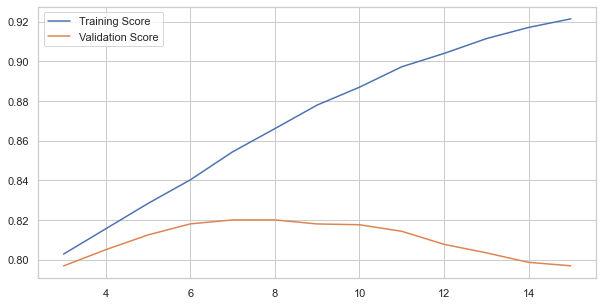

In [395]:
%%time
#Acha profundidade com melhor capacidade de generalização

#Separa Variaveis preditoras e alvo
X = df.drop('TARGET', axis=1)
y = df['TARGET']
    
#Divide dados de treino e validação   
x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
       
#Cria um dicionario para receber os scores do cross validation
scores = dict()

#Aplica um loop for percorren uma lista de valores
for i in np.arange(3,16,1):
    
    #Cria estratégia de crossvalidate
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    #Define metricas
    scoring = ['roc_auc']
    
    #Cria modelo
    model =  RandomForestClassifier(max_depth=i, n_jobs=-1, class_weight='balanced_subsample')   
    
    #Treina com validação cruzada
    results = cross_validate(model, x_train, y_train.values.ravel(), scoring=scoring, cv=cv, return_train_score=True)
    
    #Retorna scores para o hiperparametro testado
    scores[i] = results['train_roc_auc'].mean(), results['test_roc_auc'].mean(), results['test_roc_auc'].std()

#Cria um Dataframe com os scores para cada hiperparametro testado
scores_frame = pd.DataFrame(scores).transpose()
scores_frame.columns = ['Training Score','Validation Score', 'Validation Std']
scores_frame['Min'] = scores_frame['Validation Score'] - (2 * scores_frame['Validation Std'])
scores_frame['Max'] = scores_frame['Validation Score'] + (2 * scores_frame['Validation Std'])

#Plota o score medio de treino e validação para cada hiperparametro testado
scores_frame[['Training Score','Validation Score']].plot(figsize = (10, 5))

#Imprime tabela de scores
scores_frame

### Feature Selection

Wall time: 2min 37s


,importance
var15,0.0513
saldo_var30,0.0501
num_var30,0.0429
saldo_var42,0.0428
num_meses_var5_ult3,0.0414
...,...
ind_var43_emit_ult1,0.0003
var21,0.0003
ind_var37_cte,0.0003
num_op_var39_hace3,0.0001


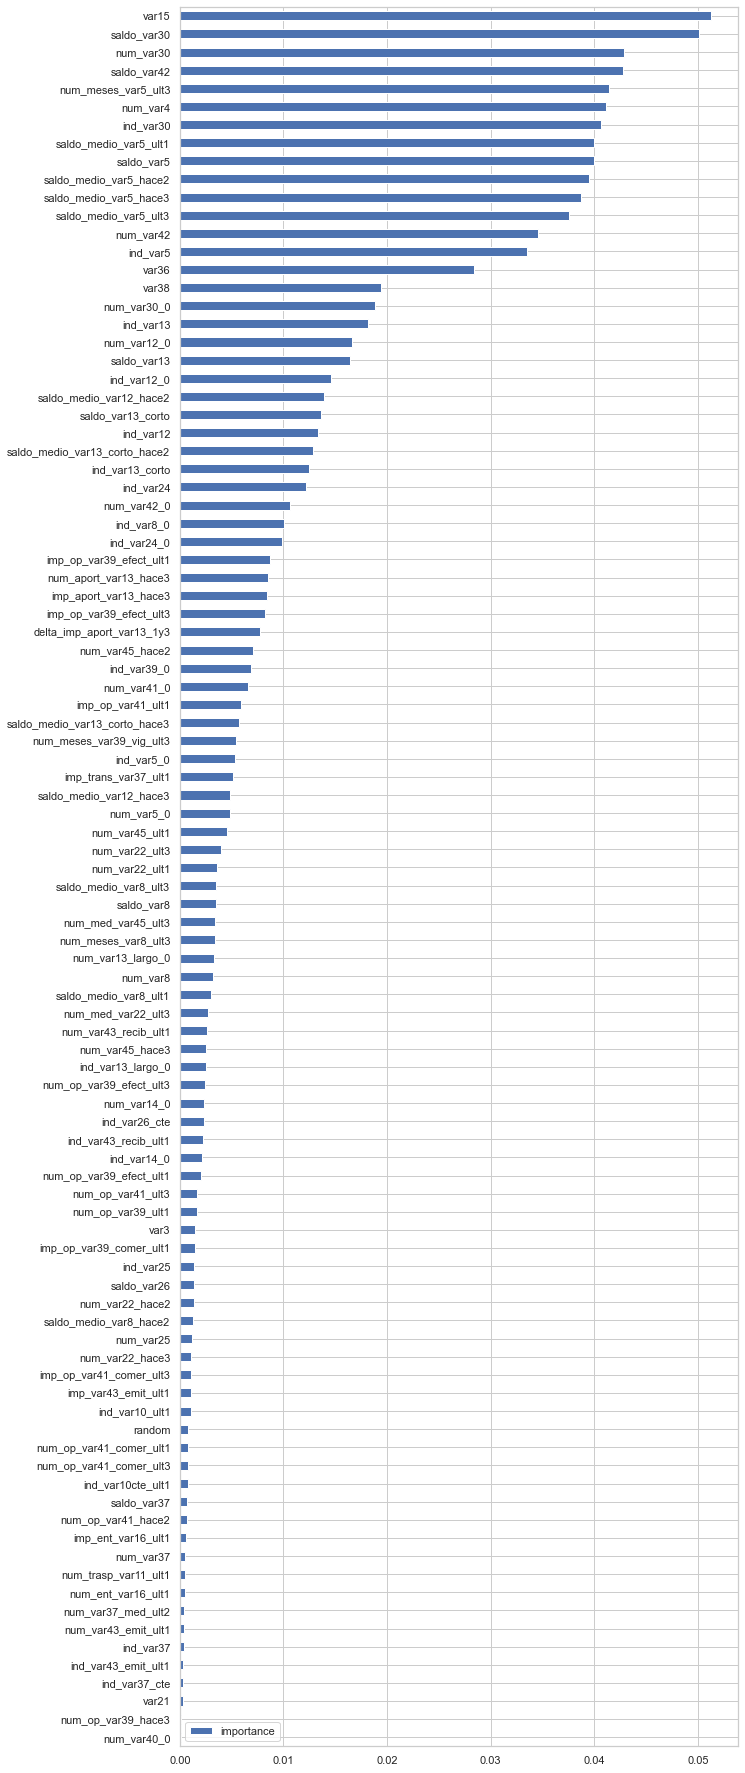

In [43]:
%%time
####FEATURE SELECTION (RANDOMFOREST, GRANDE, RASO)

#Separa Variaveis preditoras e alvo
X = df.drop('TARGET', axis=1)
y = df['TARGET']

#Adiciona uma coluna aleatoria
X['random'] = np.random.rand(X.shape[0])

#Normaliza os dados (escala entre 0 e 1)
#X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
    
#Divide dados de treino e validação   
x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
    
#Cria estratégia de crossvalidate
cv = StratifiedKFold(n_splits=10, shuffle=True)    
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
        
# Cria um classificador com muitas arrvores rasas e com poucas fetures selecionadas para divisão de nó
model = RandomForestClassifier(n_estimators=2000, max_depth=2, max_features=3, n_jobs=-1,class_weight = 'balanced_subsample')

#Define metricas
scoring = ['roc_auc']

#Treina com validação cruzada
results = cross_validate(model, x_train, y_train.values.ravel(), scoring=scoring, cv=cv, return_train_score=True, return_estimator=True)
      
#Retorna scores para o min_samples_leaf testado
#scores[i] = results['train_roc_auc'].mean(), results['test_roc_auc'].mean(), results['test_roc_auc'].std()

#Cria uma lista para receber as feature importances
feature_importances_list = []

#Executa um loop for por todos os estimadores retornados do crossvalidation
for idx, estimator in enumerate(results['estimator']):
    
    #Cria um dataframe com as importancias do estimador da vez
    feature_importances = pd.DataFrame(estimator.feature_importances_
                                       , index = x_train.columns, columns=['importance']).sort_index()
    
    #Adiciona o dataframe a uma lsita de dataframes
    feature_importances_list.append(feature_importances)

#Cria um data frame com a importancia media a partir da lista de feature importances
feature_importances_mean = round(sum(feature_importances_list) / cv.get_n_splits(),4).sort_values('importance', ascending=False)

#Plota feature importance
feature_importances_mean.sort_values('importance').plot(kind='barh', figsize=(10,x_train.shape[1]/3))

#imprime tabela de feature importance
feature_importances_mean

In [44]:
#Lista variaveis com importancia menor que a variavel RANDOM
cols_drop = feature_importances_mean['random':].drop('random').sort_index().index.to_list()

#Exclui variaveis com importancia menor que a variavel RANDOM
df.drop(cols_drop, axis=1, inplace=True)

print("New shape: ", df.shape)

New shape:  (76020, 82)


Wall time: 42.1 s


,Training Score,Validation Score,Validation Std,Min,Max
6,0.845356,0.819180,0.007795,0.803590,0.834769
7,0.859423,0.822323,0.005091,0.812142,0.832504
8,0.869593,0.819580,0.001468,0.816644,0.822515
9,0.881531,0.819257,0.004112,0.811032,0.827482
10,0.892650,0.819565,0.005397,0.808770,0.830359
11,0.900617,0.813646,0.009002,0.795642,0.831649
12,0.908713,0.809056,0.012384,0.784289,0.833823


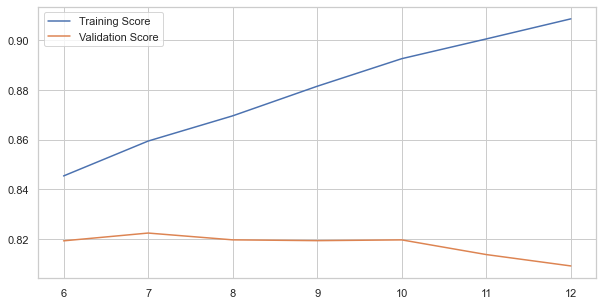

In [45]:
%%time
#Acha profundidade com melhor capacidade de generalização

#Separa Variaveis preditoras e alvo
X = df.drop('TARGET', axis=1)
y = df['TARGET']
    
#Divide dados de treino e validação   
x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
       
#Cria um dicionario para receber os scores do cross validation
scores = dict()

#Aplica um loop for percorren uma lista de valores
for i in np.arange(6,13,1):
    
    #Cria estratégia de crossvalidate
    cv = StratifiedKFold(n_splits=3, shuffle=True)
    
    #Define metricas
    scoring = ['roc_auc']
    
    #Cria modelo
    model =  RandomForestClassifier(max_depth=i, n_jobs=-1, class_weight='balanced_subsample')   
    
    #Treina com validação cruzada
    results = cross_validate(model, x_train, y_train.values.ravel(), scoring=scoring, cv=cv, return_train_score=True)
    
    #Retorna scores para o hiperparametro testado
    scores[i] = results['train_roc_auc'].mean(), results['test_roc_auc'].mean(), results['test_roc_auc'].std()

#Cria um Dataframe com os scores para cada hiperparametro testado
scores_frame = pd.DataFrame(scores).transpose()
scores_frame.columns = ['Training Score','Validation Score', 'Validation Std']
scores_frame['Min'] = scores_frame['Validation Score'] - (2 * scores_frame['Validation Std'])
scores_frame['Max'] = scores_frame['Validation Score'] + (2 * scores_frame['Validation Std'])

#Plota o score medio de treino e validação para cada hiperparametro testado
scores_frame[['Training Score','Validation Score']].plot(figsize = (10, 5))

#Imprime tabela de scores
scores_frame

In [46]:
#Ponto de Restauração
df_bk4 = df.copy()
df = df_bk4.copy()

# Modelo V1

In [55]:
%%time
#Separa Variaveis preditoras e alvo
X = df.drop('TARGET', axis=1)
y = df['TARGET']

scores = []
for i in range(20):
    #Separa Dados de Treino e Validação   
    x_train, x_test, y_train, y_test = train_test_split(  X , y, test_size=0.20  )

    #Balanceamento de Dados de Treino
    #x_train, y_train = SMOTE().fit_resample(x_train, y_train)

    #Cria Modelo
    model =  RandomForestClassifier(max_depth=10, n_jobs=-1, class_weight='balanced_subsample')

    #Treina modelo
    model.fit(x_train, y_train)

    #Faz previsoes com dados de teste
    p = model.predict(x_test)

    #Avalia modelo
    score = roc_auc_score(y_test, p)
    scores.append(score)
    
    print('Rodada:', i, 'score:', score)
#    print('roc_auc_treino: ', roc_auc_score(y_train, model.predict(x_train)))
#    print('roc_auc_teste: ', roc_auc_score(y_test, p))
#    print(classification_report(y_test, p))
#    print('Confusion Matrix:\n', confusion_matrix(y_test, p))

scores_mean = np.mean(scores)
scores_std = np.std(scores)
print('\nroc_auc_teste_mean: ', scores_mean)
print('roc_auc_teste_std:  ', scores_std)
print('\nNumero de Features: ', x_train.shape[1])
print('Lista de Features:  ', x_train.columns.to_list())

Rodada: 0 score: 0.7495870723044042
Rodada: 1 score: 0.7532190231334122
Rodada: 2 score: 0.7466320894985768
Rodada: 3 score: 0.7529300904409959
Rodada: 4 score: 0.7467842144044968
Rodada: 5 score: 0.7337456874702925
Rodada: 6 score: 0.7495270767686532
Rodada: 7 score: 0.7584474167956655
Rodada: 8 score: 0.7334769675136461
Rodada: 9 score: 0.7368149604699802
Rodada: 10 score: 0.7550379883857684
Rodada: 11 score: 0.7561087304091302
Rodada: 12 score: 0.7365956253015166
Rodada: 13 score: 0.7500879957448563
Rodada: 14 score: 0.7535599554753241
Rodada: 15 score: 0.7197250725763571
Rodada: 16 score: 0.7606276267041543
Rodada: 17 score: 0.7480479562251133
Rodada: 18 score: 0.7454317516369535
Rodada: 19 score: 0.7450277248096577

roc_auc_teste_mean:  0.7465707513034477
roc_auc_teste_std:   0.009803634625707902

Numero de Features:  81
Lista de Features:   ['var3', 'var15', 'imp_op_var39_comer_ult1', 'imp_op_var41_comer_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_u

In [56]:
#Cria um dataframe com as importancias do estimador da vez
feature_importances = pd.DataFrame(model.feature_importances_, index = x_train.columns
                                   , columns=['importance']).sort_values('importance', ascending=False)
feature_importances_lst = feature_importances.index.to_list()
feature_importances_lst

['var15',
 'saldo_var30',
 'saldo_var42',
 'saldo_medio_var5_hace2',
 'var38',
 'saldo_medio_var5_ult1',
 'saldo_var5',
 'num_meses_var5_ult3',
 'num_var4',
 'saldo_medio_var5_ult3',
 'saldo_medio_var5_hace3',
 'ind_var30',
 'num_var30',
 'num_var22_ult3',
 'imp_op_var39_efect_ult3',
 'num_var42',
 'num_var45_hace3',
 'num_var22_hace2',
 'var36',
 'num_med_var45_ult3',
 'num_var30_0',
 'num_var45_ult1',
 'num_var45_hace2',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'num_var22_ult1',
 'num_med_var22_ult3',
 'num_var22_hace3',
 'imp_op_var41_comer_ult3',
 'saldo_var13',
 'num_op_var41_ult3',
 'num_op_var39_efect_ult3',
 'imp_trans_var37_ult1',
 'num_op_var39_ult1',
 'imp_op_var39_comer_ult1',
 'num_op_var41_comer_ult3',
 'ind_var5',
 'var3',
 'num_meses_var39_vig_ult3',
 'imp_var43_emit_ult1',
 'num_op_var41_comer_ult1',
 'ind_var12_0',
 'num_var42_0',
 'ind_var13',
 'num_op_var39_efect_ult1',
 'num_var12_0',
 'saldo_var8',
 'saldo_medio_var13_corto_hace2',
 'saldo_medio_var12_ha

In [59]:
feature_importances_lst = ['var15',
'saldo_var30',
'saldo_var42',
'saldo_medio_var5_hace2',
'var38',
'saldo_medio_var5_ult1',
'saldo_var5',
'num_meses_var5_ult3',
'num_var4',
'saldo_medio_var5_ult3',
'saldo_medio_var5_hace3',
'ind_var30',
'num_var30',
'num_var22_ult3',
'imp_op_var39_efect_ult3',
'num_var42',
'num_var45_hace3',
'num_var22_hace2',
'var36',
'num_med_var45_ult3',
'num_var30_0',
'num_var45_ult1',
'num_var45_hace2',
'imp_op_var41_ult1',
'imp_op_var39_efect_ult1',
'num_var22_ult1',
'num_med_var22_ult3',
'num_var22_hace3',
'imp_op_var41_comer_ult3',
'saldo_var13',
'num_op_var41_ult3',
'num_op_var39_efect_ult3',
'imp_trans_var37_ult1',
'num_op_var39_ult1',
'imp_op_var39_comer_ult1',
'num_op_var41_comer_ult3',
'ind_var5',
'var3',
'num_meses_var39_vig_ult3',
'imp_var43_emit_ult1',
'num_op_var41_comer_ult1',
'ind_var12_0',
'num_var42_0',
'ind_var13',
'num_op_var39_efect_ult1',
'num_var12_0',
'saldo_var8',
'saldo_medio_var13_corto_hace2',
'saldo_medio_var12_hace2',
'saldo_medio_var8_ult1',
'saldo_medio_var8_ult3',
'saldo_var13_corto',
'num_var43_recib_ult1',
'ind_var13_corto',
'ind_var8_0',
'delta_imp_aport_var13_1y3',
'num_var41_0',
'ind_var10cte_ult1',
'ind_var24',
'ind_var12',
'saldo_medio_var8_hace2',
'ind_var10_ult1',
'ind_var24_0',
'num_meses_var8_ult3',
'saldo_var26',
'num_var8',
'ind_var39_0',
'ind_var43_recib_ult1',
'num_var5_0',
'num_aport_var13_hace3',
'imp_aport_var13_hace3',
'ind_var5_0',
'saldo_medio_var12_hace3',
'ind_var14_0',
'saldo_medio_var13_corto_hace3',
'ind_var26_cte',
'num_var25',
'num_var13_largo_0',
'num_var14_0',
'ind_var25',
'ind_var13_largo_0'
]


Wall time: 13min 15s


,Training Score,Validation Score,Validation Std,Min,Max
1,0.719510,0.705895,0.006099,0.693696,0.718094
2,0.856532,0.804504,0.008330,0.787845,0.821163
3,0.854996,0.805745,0.007311,0.791122,0.820367
4,0.867294,0.803802,0.010776,0.782249,0.825354
5,0.889661,0.818799,0.007072,0.804656,0.832942
...,...,...,...,...,...
76,0.888438,0.817633,0.008438,0.800756,0.834510
77,0.887195,0.816806,0.008766,0.799274,0.834339
78,0.887626,0.817111,0.007491,0.802129,0.832093
79,0.885806,0.814981,0.010946,0.793089,0.836873


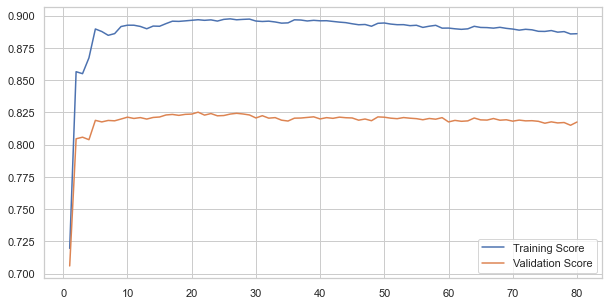

In [60]:
%%time
#Treina o modelo adicionando uma feature por vez em ordem de importancia para achar o ponto de corte 
#que apresete o melhor desempenho com o menor número de features

#Separa Variaveis preditoras e alvo
X = df.drop('TARGET', axis=1)
y = df['TARGET']
    
#Divide dados de treino e validação   
x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
       
#Cria um dicionario para receber os scores do cross validation
scores = dict()

#Aplica um loop for percorren uma lista de valores
for i in np.arange(1,81,1):
    
    #Cria estratégia de crossvalidate
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    #Define metricas
    scoring = ['roc_auc']
    
    #Cria modelo
    model =  RandomForestClassifier(max_depth=10, n_jobs=-1, class_weight='balanced_subsample')   
    
    #Treina com validação cruzada
    results = cross_validate(model, x_train[feature_importances_lst[:i]], y_train.values.ravel(), scoring=scoring, cv=cv, return_train_score=True)
    
    #Retorna scores para o hiperparametro testado
    scores[i] = results['train_roc_auc'].mean(), results['test_roc_auc'].mean(), results['test_roc_auc'].std()

#Cria um Dataframe com os scores para cada hiperparametro testado
scores_frame = pd.DataFrame(scores).transpose()
scores_frame.columns = ['Training Score','Validation Score', 'Validation Std']
scores_frame['Min'] = scores_frame['Validation Score'] - (2 * scores_frame['Validation Std'])
scores_frame['Max'] = scores_frame['Validation Score'] + (2 * scores_frame['Validation Std'])

#Plota o score medio de treino e validação para cada hiperparametro testado
scores_frame[['Training Score','Validation Score']].plot(figsize = (10, 5))

#Imprime tabela de scores
scores_frame

In [61]:
scores_frame

,Training Score,Validation Score,Validation Std,Min,Max
1,0.719510,0.705895,0.006099,0.693696,0.718094
2,0.856532,0.804504,0.008330,0.787845,0.821163
3,0.854996,0.805745,0.007311,0.791122,0.820367
4,0.867294,0.803802,0.010776,0.782249,0.825354
5,0.889661,0.818799,0.007072,0.804656,0.832942
...,...,...,...,...,...
76,0.888438,0.817633,0.008438,0.800756,0.834510
77,0.887195,0.816806,0.008766,0.799274,0.834339
78,0.887626,0.817111,0.007491,0.802129,0.832093
79,0.885806,0.814981,0.010946,0.793089,0.836873


In [62]:
scores_frame['Validation Score'].idxmax()

21

In [66]:
%%time
#Separa Variaveis preditoras e alvo
X = df[feature_importances_lst[:21]]
y = df['TARGET']

scores = []
for i in range(3):
    #Separa Dados de Treino e Validação   
    x_train, x_test, y_train, y_test = train_test_split(  X , y, test_size=0.20  )

    #Balanceamento de Dados de Treino
    #x_train, y_train = SMOTE().fit_resample(x_train, y_train)

    #Cria Modelo
    model =  RandomForestClassifier(max_depth=10, n_jobs=-1, class_weight='balanced_subsample')

    #Treina modelo
    model.fit(x_train, y_train)

    #Faz previsoes com dados de teste
    p = model.predict(x_test)

    #Avalia modelo
    score = roc_auc_score(y_test, p)
    scores.append(score)
    
    print('Rodada:', i, 'score:', score)
#    print('roc_auc_treino: ', roc_auc_score(y_train, model.predict(x_train)))
#    print('roc_auc_teste: ', roc_auc_score(y_test, p))
#    print(classification_report(y_test, p))
#    print('Confusion Matrix:\n', confusion_matrix(y_test, p))

scores_mean = np.mean(scores)
scores_std = np.std(scores)
print('\nroc_auc_teste_mean: ', scores_mean)
print('roc_auc_teste_std:  ', scores_std)
print('\nNumero de Features: ', x_train.shape[1])
print('Lista de Features:  ', x_train.columns.to_list())

Rodada: 0 score: 0.7438805381267878
Rodada: 1 score: 0.7368126222127378
Rodada: 2 score: 0.7436169003149833

roc_auc_teste_mean:  0.7414366868848363
roc_auc_teste_std:   0.0032714784418022436

Numero de Features:  21
Lista de Features:   ['var15', 'saldo_var30', 'saldo_var42', 'saldo_medio_var5_hace2', 'var38', 'saldo_medio_var5_ult1', 'saldo_var5', 'num_meses_var5_ult3', 'num_var4', 'saldo_medio_var5_ult3', 'saldo_medio_var5_hace3', 'ind_var30', 'num_var30', 'num_var22_ult3', 'imp_op_var39_efect_ult3', 'num_var42', 'num_var45_hace3', 'num_var22_hace2', 'var36', 'num_med_var45_ult3', 'num_var30_0']
Wall time: 7.45 s


In [67]:
#Carregando dados novos
diretorio = 'C:/Users/mateus.sehn/OneDrive/Cursos/Big_Data_Real-Time_Com_Python_e_Spark/12-Projetos_Com_Feedback/'
arquivo = 'test.csv'

test = pd.read_csv(diretorio+arquivo)                  
test.head()

#Lista de variaveis finais
cols = feature_importances_lst[:21]


#Filtra dados novos
x_new = test[cols]


#Trantando outlier na VAR3
#x_new['var3'].replace(-999999, -1, inplace=True)


#Separa Coluna de ID
ID = test['ID']

#Faz previsoes e converte em data frame
TARGET = pd.DataFrame()
TARGET['TARGET'] = model.predict(x_new)

#Criando datafram com ID e TARGET
submission = pd.merge(left=ID, right=TARGET, left_index=True, right_index=True)

#Salvando o arquivo submission
submission.to_csv('submission202110262324.csv', index=False)

#Imprime resultado
submission

,ID,TARGET
0,2,0
1,5,0
2,6,0
3,7,0
4,9,0
...,...,...
75813,151831,1
75814,151832,0
75815,151833,0
75816,151834,0


Score Kaggle\
Name                                    Score
submission202110262324.csv             0.73562

Podemos seguir daqui com transformações como onehot encoder, scaler, features polynomiais e outros modelos mais robustos, porém atingimos o objetivo definido no inicio do projeto de atingir uma acuracia acima de 70%

In [184]:
print('roc_auc_treino: ', roc_auc_score(y_train, model.predict(x_train)))
print('roc_auc_teste: ', roc_auc_score(y_test, p))
print(classification_report(y_test, p))
print('Confusion Matrix:\n', confusion_matrix(y_test, p))

roc_auc_treino:  0.8056180134347712
roc_auc_teste:  0.7592343176827521
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     14607
           1       0.15      0.68      0.24       597

    accuracy                           0.83     15204
   macro avg       0.57      0.76      0.57     15204
weighted avg       0.95      0.83      0.88     15204

Confusion Matrix:
 [[12271  2336]
 [  192   405]]


# Fim